In [45]:
import pandas as pd
import ast

In [83]:
def upload_dataset():
    df = pd.read_csv("../data/movies_metadata_cleaned_v1.csv", index_col=0)
    required_columns = [
        "id",
        "imdb_id",
        "title",
        "genres",
        "original_title",
        "overview",
        "cast",
        "poster_path",
        "director",
    ]
    df = df[required_columns]

    df["combined_rows"] = df.apply(
        lambda x: f"The movie {x['title']} is directed by {x['director']} and has the following genres ({', '.join(ast.literal_eval(x['genres']))}) and the cast includes ({', '.join(ast.literal_eval(x['cast']))}) and the overview is {x['overview']}",
        axis=1,
    )
    return df

In [116]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [117]:
import requests

df = upload_dataset()

OMDP_API_KEY = os.getenv("OMDP_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
QDRANT_URL = os.getenv("QDRANT_URL")


def get_poster(imdb_id: int, omdp_api_key: str = OMDP_API_KEY):
    url = f"http://www.omdbapi.com/?apikey={omdp_api_key}&i={imdb_id}"
    response = requests.get(url)
    data = response.json()
    return data["Poster"]

In [108]:
from qdrant_client import QdrantClient, models

In [118]:
client = QdrantClient(
    url=QDRANT_URL,
    api_key=os.getenv("QDRANT_API_KEY"),
)

client.get_collections()

CollectionsResponse(collections=[CollectionDescription(name='movies_metadata')])

In [51]:
combined_rows_list = df["combined_rows"].to_list()

In [52]:
from llama_index.embeddings.openai import OpenAIEmbedding

In [53]:
embed_model = OpenAIEmbedding(model="text-embedding-3-small", api_key=OPENAI_API_KEY)

In [10]:
with open("embedded_combined_rows.txt", "r") as f:
    embedded_combined_rows = f.read()

In [11]:
import json

embedded_combined_rows_list = json.loads(embedded_combined_rows)

In [14]:
client.upload_points(
    collection_name="movies_metadata",
    points=[
        models.PointStruct(
            id=movies_df["id"],
            vector=embedded_combined_rows_list[idx],
        )
        for idx, movies_df in df.iterrows()
    ],
)

In [54]:
query = embed_model.get_text_embedding(
    "A movie in the medival times with dragons and magic"
)

In [55]:
res = client.search(
    collection_name="movies_metadata",
    query_vector=query,
    limit=3,
)

In [56]:
res

[ScoredPoint(id=16923, version=528, score=0.603153, payload={}, vector=None, shard_key=None),
 ScoredPoint(id=27273, version=96, score=0.6020055, payload={}, vector=None, shard_key=None),
 ScoredPoint(id=848, version=96, score=0.58566904, payload={}, vector=None, shard_key=None)]

In [101]:
from IPython.display import Image, display

-----------------------------------
Merlin and the War of the Dragons
In 5th Century Britian, a young Merlin struggles for his place in his known land under the tutelage of The Mage, a local wizard whom sees the young man's potential for magic, as well as face off against his evil former friend, Vendiger, whom plots with a feudal warlord king to conquer all of Britian using an army of flying dragons, and only Merlin with the alliance of the local Prince Uther and Ingraine and a pair of mystical goddesses, can have the power to stop the evil from taking over the land.
imdb_id is: tt1294699


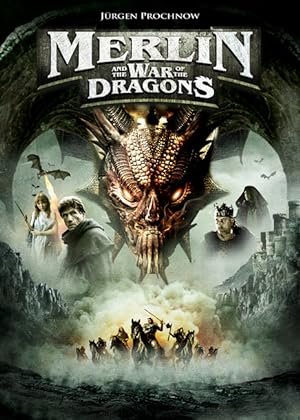

-----------------------------------
The Flight of Dragons
The realm of magic is being threatened by the realm of logic, so Carolinus, the green wizard decides to shield it for all time. Ommedon, the evil red wizard, stands in his way. Carolinus then calls for a quest that is to be led by a man named Peter Dickinson, who is the first man of both the realms of science and magic. It is Peters job to defeat Ommedon.
imdb_id is: tt0083951


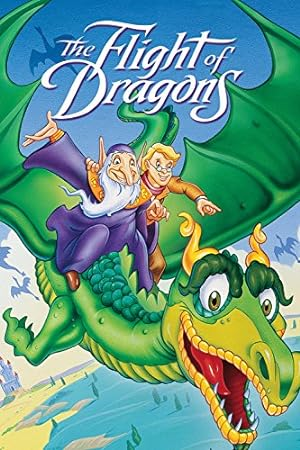

-----------------------------------
Dragonslayer
The sorcerer and his apprentice Galen are on a mission to kill an evil dragon in order to save the King’s daughter from being sacrificed in accordance to a pact that the King himself made with the dragon to protect his kingdom. A fantasy film from Disney Studios that exhausted all possible visual effects of the time.
imdb_id is: tt0082288


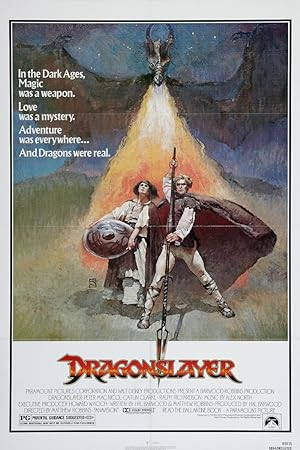

In [103]:
for movies in res:
    dataframe = df[df["id"] == movies.id]
    print("-" * 35)
    print(dataframe["title"].values[0])
    print(dataframe["overview"].values[0])
    print(f'imdb_id is: {dataframe["imdb_id"].values[0]}')
    display(Image(get_poster(dataframe["imdb_id"].values[0])))